#  Automatically Classifying Tweets from Donald Trump

##### August 27th, 2018
## Table of Contents

### [1. Project Overview](#overview)
### [2. Problem Statement](#statement)
### [3. Solution Strategy](#solution)
### [4. Evaluation Metrics](#metrics)
### [5. Data Exploration](#exploration)
### [6. Data Cleaning](#cleaning)
### [7. Data Visualization](#visualization)
### [8. Data Preparation](#preparation)
### [9.Modelling](#model)
### [10. Category Generation](#pred)
### [11. Conclusions and Further Improvement](#conclusion)



<a id='overview'></a>
## Project Overview

Tweets are a short, easy way to send a message or express an opinion. And no opinion is more frequently debated than that of the current POTUS, Donald Trump. Trump frequently uses Twitter to express his opinion of a current event, of some topic, or just to state his mind on something. However, his tweets can be condensed to mostly a net of certain topics. In this project, we are aiming to create a model that given a tweet from Trump, it will output a class for that tweet, or no class at all, in case the tweet is not similar to any class at all.

<a id='statement'></a>
## Problem Statement

As mentioned in the previous section, the tweets can be classified into a certain number of classes or categories. This project is looking to use the raw content of a tweet to assign one or multiple categories to a tweet.  Because of the nature of the data (text tweets), and the objective of the problem (Classifying multiple categories),  we are faced with a **Multilabel Classification** Problem.


<a id='solution'></a>
## Solution Strategy

Given the nature of the problem at hand, a lot of algorithms are not well optimized for the problem. Not a lot of algorithms come with multilabel classification built-in. There are alternative methods to train multilabel classifiers, such as training one model per label. However, since we are predicting news keywords, which are numerous in unique labels, this approach is not technically feasible. Because of these reasons, three algorithms that have multilabel classification built-in will be evaluated: Random Forest, K-Nearest Neighbors and a Neural Network.

The data cleaning process is key in this project, since the raw data consists of strings that are tweets. We'll also use the Term Frequency-Inverse Document Frequency algorithm to convert the cleaned article content into numerical format, for easier consumption for the learning algorithms. Finally, we'll use cross validation and parameter optimization to obtain the best model, and use it to predict news keywords for a large number of articles in the data that are missing keywords.

<a id='metrics'></a>
## Evaluation Metrics

To measure the quality of the multilabel classification algorithm, we'll use a metric that takes both multiple lables into account, and the rarity of some keywords. We'll use the <a href="https://en.wikipedia.org/wiki/F1_score">F1 Score</a> metric. This metric is the harmonic mean of two other metrics **Precision** and **Recall**. 

- Precision is the amount of true positives, positive instances that were classified correctly, divided by the sum of true   positives and false positives, negative instances that were classified as positive. This metric measures how well the model avoids assigning the wrong keyword to an article. 

- Recall is the amount of true positives, positive instances that were classified correctly, divided by the sum of true   positives and false negatives, positive instances that were classified as negative. This metric measures how well the model  assigns  keywords correctly to an article. 


The harmonic mean of these two metrics, results in the F1 Score. This means that it takes both, how well the model avoids the wrong categories, and how well the model assigns the correct categories. Since some categories appear infrequently, we can't use accuracy as a metric, as predicting no categories most of the time will yield high accuracy. We'll use a weighted version of this metric, which takes into account how often a label appears in the data, and works better overall for evaluating multilabel classification. 

<a id='exploration'></a>
## Data Exploration

The dataset used in this project is a tweet dataset. This dataset contains information about the tweet itself, its topics and the timestamp in which the tweet was created.

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.normalization import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import re #Regular Expressions.
from nltk.corpus import stopwords
import keras as Ke
from numpy.random import seed
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
warnings.filterwarnings("ignore")
%matplotlib inline
seed(777)
pd.options.mode.chained_assignment = None
english_stopwords = set(stopwords.words('english'))

C:\Users\jcorporan\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 12
rcParams["patch.force_edgecolor"] = True
sns.set()

In [3]:
tweets = pd.read_excel('trump political tweets_upwork_v2.xlsx')
tweets.head()

,User ID,Timestamp,Text,ToxicityScore,Topic 1,Topic 2,Topic 3
0,25073877,Tue Aug 09 13:50:25 +0000 2011,My interview with Greta last night on Fox News...,0.086770,fox news,NaN,NaN
1,25073877,Sat Aug 13 18:02:45 +0000 2011,"Economic growth can save Social Security, Medi...",0.013618,healthcare,economy,NaN
2,25073877,Thu Aug 25 17:16:06 +0000 2011,China's corporate espionage is a continued thr...,0.237544,china,economy,NaN
3,25073877,Fri Aug 26 16:05:15 +0000 2011,There is no substitute for private sector expe...,0.096691,economy,NaN,NaN
4,25073877,Wed Aug 31 16:07:12 +0000 2011,Libya is being taken over by Islamic radicals-...,0.301112,terrorism,obama,NaN


In [4]:
tweets['Topic 2'] = tweets['Topic 2'].replace({'oil':'energy'})

In [5]:
print("The dataset contains {} tweets".format(tweets.shape[0]))

The dataset contains 19068 tweets


Let's first join the 3 topic columns into one, by joining them by commas.

In [6]:
tweets['Topics'] = tweets['Topic 1'].fillna(' ') + "," + tweets['Topic 2'].fillna(' ') + ","  + tweets['Topic 3'].fillna(' ')
tweets['Topics'] = tweets['Topics'].str.replace(', | ,','')
tweets.Topics = tweets.Topics.replace({' ':np.nan})
tweets.Topics = tweets.Topics.replace({'undetermined':np.nan})
tweets['Topics'].head()

0              fox news
1    healthcare,economy
2         china,economy
3               economy
4       terrorism,obama
Name: Topics, dtype: object

In [7]:
tweets.Text.loc[0]

'My interview with Greta last night on Fox News -- "Nation Has Become "All Talk, No Action\' "  http://bit.ly/mQo62O'

<a id='cleaning'></a>
## Data Cleaning

In this dataset, the text cleaning is pretty simple. We'll do several text cleaning tasks like: 

- Removing extra white space characters
- Removing non-alphabetic characters,
- Removing stopwords, or words that have no actual meaning in the text like and, the, or, etc. 

In [8]:
def Clean_Text(text):
    
    #Remove all non letters.
    remove_space = text.replace("\n"," ")
    letters_only = re.sub("[^a-zA-Z]"," ", text )
    
    words = letters_only.lower().split()
    
    #Remove stopwords from review.
    removed_stops = [w for w in words if not w  in english_stopwords and len(w)!=1]
    
    return " ".join(removed_stops)

In [9]:
tweets['clean_tweet'] = tweets.Text.apply(Clean_Text)
tweets.clean_tweet.loc[0]

'interview greta last night fox news nation become talk action http bit ly mqo'

With this, we are done with data cleaning. Now we can proceed to visualizing the data.

<a id='visualization'></a>
## Data Visualization

Let's take a look at the correlation between categories. Or, which categories appear frequently together.

In [10]:
import collections
from itertools import chain
#Separate multiple keywords into unique, separate keywords.
vocabulary = list(map(lambda x: x.lower().split(','), tweets.loc[pd.notnull(tweets.Topics)].Topics))
vocabulary = list(np.unique(list(chain(*vocabulary))))

In [11]:
keywords_count_vectorizer = CountVectorizer(vocabulary=vocabulary, tokenizer=lambda x: x.split(','))
X = keywords_count_vectorizer.fit_transform(tweets.loc[pd.notnull(tweets.Topics)].Topics)
count_vect_df = pd.DataFrame(X.todense(), columns=keywords_count_vectorizer.get_feature_names())
count_vect_df.head()

,china,cnn,cruz,defense,democrats,economy,energy,fake news,fox news,healthcare,...,mexico,non-political,nytimes,obama,republicans,romney,russia,sanders,syria,terrorism
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [12]:
correlations = count_vect_df.corr()

In [13]:
correlations

,china,cnn,cruz,defense,democrats,economy,energy,fake news,fox news,healthcare,...,mexico,non-political,nytimes,obama,republicans,romney,russia,sanders,syria,terrorism
china,1.000000,-0.060101,-0.042569,0.067676,-0.047026,0.033293,0.058168,-0.034284,-0.027405,-0.085857,...,-0.040048,-0.116238,-0.034864,0.010144,-0.053396,-0.041021,-0.004432,-0.031876,-0.038463,-0.032705
cnn,-0.060101,1.000000,0.004757,-0.041355,-0.041007,-0.073170,-0.045497,0.091275,0.047311,-0.084321,...,-0.034922,-0.104073,-0.003219,-0.143323,-0.046561,-0.044403,-0.024413,-0.016831,-0.024314,-0.029100
cruz,-0.042569,0.004757,1.000000,-0.024883,-0.018547,-0.051826,-0.032225,-0.025834,-0.002950,-0.031637,...,-0.024735,-0.073715,-0.026140,-0.084240,-0.032979,-0.035403,-0.028344,-0.012276,-0.023756,-0.016518
defense,0.067676,-0.041355,-0.024883,1.000000,-0.012720,-0.032316,-0.019115,0.003561,-0.033766,-0.068300,...,-0.031951,-0.095219,-0.024636,0.040242,-0.020564,-0.043672,-0.002780,-0.031743,0.029327,0.096667
democrats,-0.047026,-0.041007,-0.018547,-0.012720,1.000000,-0.051533,-0.026924,-0.007190,-0.028877,0.000503,...,-0.027324,-0.081432,-0.028877,-0.006018,0.014520,-0.040523,-0.021533,0.017634,-0.026243,-0.029891
economy,0.033293,-0.073170,-0.051826,-0.032316,-0.051533,1.000000,0.081849,-0.044534,-0.051527,-0.022849,...,0.044463,-0.145302,-0.051527,0.105349,-0.044678,-0.056381,-0.055869,-0.048439,-0.039906,-0.058130
energy,0.058168,-0.045497,-0.032225,-0.019115,-0.026924,0.081849,1.000000,-0.031664,-0.022457,-0.073201,...,-0.030316,-0.090349,-0.032039,0.092202,-0.040421,-0.052308,0.000767,-0.030119,-0.018619,-0.019996
fake news,-0.034284,0.091275,-0.025834,0.003561,-0.007190,-0.044534,-0.031664,1.000000,0.021476,-0.052971,...,-0.024304,-0.072429,0.056847,-0.097705,-0.032404,-0.041934,0.026762,-0.011641,-0.010425,-0.024730
fox news,-0.027405,0.047311,-0.002950,-0.033766,-0.028877,-0.051527,-0.022457,0.021476,1.000000,-0.048082,...,-0.024592,-0.068426,0.020647,0.034252,-0.014029,0.052660,0.004222,-0.024432,-0.023619,-0.007207
healthcare,-0.085857,-0.084321,-0.031637,-0.068300,0.000503,-0.022849,-0.073201,-0.052971,-0.048082,1.000000,...,-0.056186,-0.167445,-0.059379,0.523991,-0.043104,-0.072138,-0.048686,-0.055821,-0.047775,-0.069511


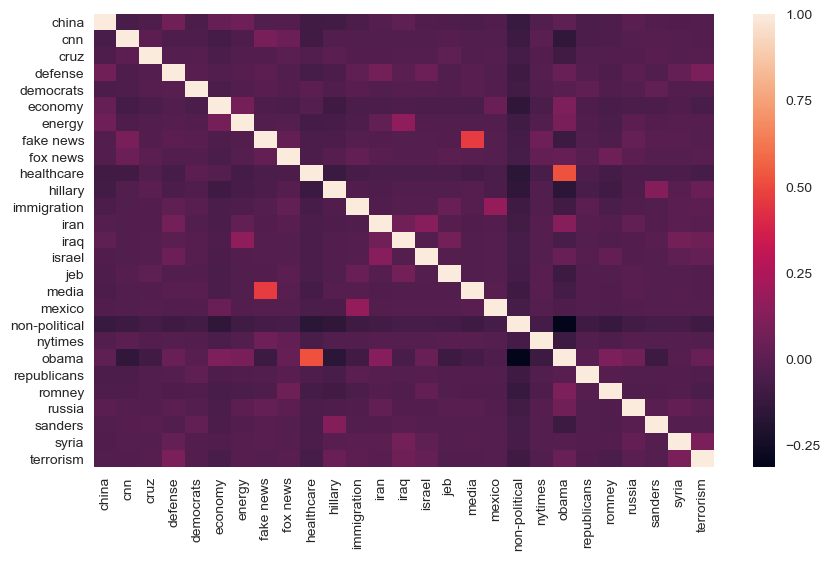

In [14]:
sns.heatmap(correlations)

Two strongly correlated category combinations are fake news and media, and also healthcare and obama. These may be related because the media is often the one that spreads news and because of ObamaCare, respectively. 

Now that we are done with data visualization, let's move on to preparing the data for modelling.

<a id='preparation'></a>
## Data Preparation

Machine Learning models only take numbers as input. This means we have to convert our tweets, which are composed of text, into numbers. To perform this task, there are several methods, such as: 

- Counting the number of appearances of each unique word in each tweet. This leaves us with a matrix in which each value represents the number of times a word appears in the tweet. 

- TF-IDF. Assign scores to each word, base on how common they are on a specific tweet, and how uncommon they are accross all tweetss as a whole. 

For this problem we'll use TF-IDF, since in practice it usually performs better than just a word count. To create the TF-IDF matrix, we first have to assign the limits of the percentage of frequency of words. This prevents words that are too rare (words that appear only once or twice), or words that appear too frequently from being included into the matrix. We first have to split the data into a training set, by only using the tweets that have categories.

In [15]:
training_data = tweets.loc[pd.notnull(tweets.Topics)].reset_index(drop=True)
print("The training data contains {} articles".format(training_data.shape[0]))
training_data.head()

The training data contains 3474 articles


,User ID,Timestamp,Text,ToxicityScore,Topic 1,Topic 2,Topic 3,Topics,clean_tweet
0,25073877,Tue Aug 09 13:50:25 +0000 2011,My interview with Greta last night on Fox News...,0.086770,fox news,NaN,NaN,fox news,interview greta last night fox news nation bec...
1,25073877,Sat Aug 13 18:02:45 +0000 2011,"Economic growth can save Social Security, Medi...",0.013618,healthcare,economy,NaN,"healthcare,economy",economic growth save social security medicare ...
2,25073877,Thu Aug 25 17:16:06 +0000 2011,China's corporate espionage is a continued thr...,0.237544,china,economy,NaN,"china,economy",china corporate espionage continued threat ame...
3,25073877,Fri Aug 26 16:05:15 +0000 2011,There is no substitute for private sector expe...,0.096691,economy,NaN,NaN,economy,substitute private sector experience
4,25073877,Wed Aug 31 16:07:12 +0000 2011,Libya is being taken over by Islamic radicals-...,0.301112,terrorism,obama,NaN,"terrorism,obama",libya taken islamic radicals barackobama open ...


In [16]:
TfIdfVect = TfidfVectorizer(min_df=0.0025,max_df=0.5)
TfIdfVect.fit(training_data.clean_tweet)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=0.0025,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

We can inspect the size of the vocabulary created.

In [17]:
print("The vocabulary contains {} distinct words.".format(len(TfIdfVect.get_feature_names())))

The vocabulary contains 841 distinct words.


We can use this vectorizer created to convert the cleaned articles into a tf-idf matrix.

In [18]:
score_matrix = TfIdfVect.transform(training_data.clean_tweet)
score_matrix.shape

(3474, 841)

Finally, we'll use the tag count matrix created earlier, to assign our training data and training labels.

In [19]:
x_train = score_matrix.todense()
y_train = (count_vect_df > 0).values.astype(np.int8)

With our data created, we can proceed to modelling. 

<a id='model'></a>
## Modelling

As mentioned previously, the models we can use are limited to those that support multilabel classification in a light way. By this, it means that we don't have to use multiple One Vs Rest classifiers to create the model. Using multiple One Vs Rest classifiers is very computationally inefficient, because this entails creating one model per category, then using all models during prediction time. This means training a large number of models, which will only increase in number when the number of categories increase. Due to these limitations, we decided on three posible classifiers: 

- Random Forests: Creates multiple decision trees, statistical data structures that split the data according to criteria which divide the label best, and averages them to create a more balanced prediction. 

- K-Nearest Neighbors: Assigns points to the data, compares them using a distance metric, and assigns a classification based on the labels of the nearest points. 

- Neural Network: Computes several matrix multiplications to approximate a function from its input to its output. 

All of these support multilabel classification from the get go. However, for Random Forests and KNN, it's better to apply a dimensionality reduction technique to the data before training. Neural Networks work better with high dimensional data, so for these models this step isn't needed. For the dimensionality reduction algorithm, we'll use Principal Component Analysis (PCA), which maps higher dimensional data into a lower dimension, by trying to minimize the variance between the data in a higher dimension and its possible lower dimension. Let's apply it to the TF-IDF matrix we created previously and create a new $sqrt(n)$ dimensional matrix, where n stands for the number of variables in the current, non-reduced matrix.

In [20]:
pca = PCA(n_components=np.sqrt(x_train.shape[1]).astype(int))
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_train.shape

(3474, 29)

Now, let's use cross validation, and the weighted f1 score, to evaluate these models. 

#### KNN 

In [21]:
clf = KNeighborsClassifier(n_jobs = 8,n_neighbors=3)
knn_scores = cross_val_score(clf, pca_x_train, y_train, cv=5, scoring='f1_weighted',verbose=5)
print(knn_scores)
print("Average KNN F1 Score: {}".format(knn_scores.mean()))

[CV]  ................................................................
[CV] ........................ , score=0.707906819466888, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.7407558882578175, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... , score=0.7430813912387166, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7604587240351234, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV] ....................... , score=0.7441680383576813, total=   0.0s
[0.70790682 0.74075589 0.74308139 0.76045872 0.74416804]
Average KNN F1 Score: 0.7392741722712454


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


#### Random Forest

In [22]:
dtree = RandomForestClassifier(n_jobs=4)
tree_scores = cross_val_score(dtree, pca_x_train, y_train, cv=5, scoring='f1_weighted')
tree_scores              

array([0.6263369 , 0.62723643, 0.64891623, 0.64339587, 0.63944942])

In [23]:
print("Mean Random Forest F1 Score: {}".format(tree_scores.mean()))

Mean Random Forest F1 Score: 0.6370669675424283


#### Neural Network 

For the Neural Network, we'll use the Keras library to easily create a NN architecture. We'll also create a custom class, to cross validate and evaluate the neural network, since Keras doesn't support scikit-learn levels of cross validation by default.

In [24]:
class Metrics(Ke.callbacks.Callback):
    """
    Helper class to compute evaluation metrics for the Keras neural networks.
    """
    
    
    def prepare_metrics_dict(self,logs={}):
        dic=dict()
        dic['precision'] = list()
        dic['f1s'] = list()
        dic['recall'] = list()
        return dic
    
    def on_train_begin(self, logs={}):
        self.train_dict=self.prepare_metrics_dict()
        self.val_dict=self.prepare_metrics_dict()

    def get_metrics(self,model,dic,x,y):
        score = np.asarray(model.predict(x))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        dic['precision'].append(sklm.precision_score(targ, predict,average='weighted'))
        dic['recall'].append(sklm.recall_score(targ, predict,average='weighted'))
        dic['f1s'].append(sklm.f1_score(targ, predict,average='weighted'))
        
    def on_epoch_end(self, epoch, logs={}):
        x_val,y_val = (self.validation_data[0],self.validation_data[1])
        self.get_metrics(self.model,self.val_dict,x_val,y_val)

        return

In [25]:
class KerasModel(object):
    """
    Helper class to instantiate, train and evaluate a Keras Neural Network
    """
    def __init__(self,X,y,params_dict,n_folds=5):
        self.X = X
        self.y = y
        self.metrics=dict()
        self.n_folds=n_folds
        self.params_dict=params_dict
    
    def init_metrics(self):
        dic=dict()
        dic['precision'] = list()
        dic['f1s'] = list()
        dic['recall'] = list()
        dic['f1_micro'] = list()
        dic['f1_macro'] = list()
        dic['class_f1s'] = list()
        return dic
    
    def create_model(self,params_dict):
        model = Sequential()
        #Input layer + Hidden Layer
        model.add(Dense(params_dict['layer_1_units'], input_shape=(self.X.shape[1],),kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        
        model.add(Dense(params_dict['layer_1_units'] // 2,kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        
        model.add(Dense(self.y.shape[1],kernel_initializer='glorot_normal'))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))
        model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
        self.model = model
    
    def calculate_metrics(self,model,metrics_dict,x_val,y_val):
        score = np.asarray(model.predict(x_val))
        predict = np.round(np.asarray(self.model.predict(x_val)))
        targ = y_val
        metrics_dict['precision'].append(sklm.precision_score(targ, predict,average='weighted'))
        metrics_dict['recall'].append(sklm.recall_score(targ, predict,average='weighted'))
        metrics_dict['f1s'].append(sklm.f1_score(targ, predict,average='weighted'))
        print("F1 Score: {}".format(sklm.f1_score(targ, predict,average='weighted')))
        metrics_dict['f1_macro'].append(sklm.f1_score(targ, predict,average='macro'))
        print("F1 Macro Score: {}".format(sklm.f1_score(targ, predict,average='macro')))       
        metrics_dict['f1_micro'].append(sklm.f1_score(targ, predict,average='micro'))
        print("F1 Micro Score: {}".format(sklm.f1_score(targ, predict,average='micro')))
        class_f1s = sklm.f1_score(targ,predict,average=None)
        class_f1s_dict = dict()
        for i,col in enumerate(count_vect_df.columns):
            class_f1s_dict[col] = class_f1s[i]
        metrics_dict['class_f1s'].append(class_f1s_dict)
        print(class_f1s_dict)
        
    
    def train_and_evaluate_model(self,model,metrics_obj,metrics_dict,params_dict,x_train, y_train, x_val, y_val):
        history = model.fit(x_train, y_train, 
                        batch_size=params_dict['batch_size'], 
                        epochs=params_dict['epochs'], 
                        verbose=1,
                        class_weight=balance_dict)
        self.calculate_metrics(model,metrics_dict,x_val,y_val)
    
    
    def model_cross_validation(self):
        skf = KFold(n_splits=self.n_folds, shuffle=True)
        self.metrics = self.init_metrics()
        i = 0
        for train, test in skf.split(self.X, self.y):
            print ("Running Fold", i + 1, "/", self.n_folds)
            self.model = None # Clearing the NN.
            self.create_model(self.params_dict)
            metrics_obj = Metrics()
            self.train_and_evaluate_model(self.model,metrics_obj,self.metrics,self.params_dict
                                          , self.X[train], self.y[train], self.X[test], self.y[test])
            i+=1
    
    def train_final_model(self):
        self.model = None
        self.create_model(self.params_dict)
        history = self.model.fit(self.X, self.y, 
                            batch_size=self.params_dict['batch_size'], 
                            epochs=self.params_dict['epochs'], 
                            verbose=1,
                                class_weight=balance_dict)

In [26]:
params_dict = {
    'epochs':10,
    'batch_size':8,
    'layer_1_units':1024
}

Since the classes are imbalanced, we'll also have to add class weights to each of the classes. This way, the model will pay more attention to these underrepresented classes. We do this by assigning a weight to the class, and thus, when the model misclassifies the class, it will be penalized more. To calculate this weight we use the following formula: 

$$ classWeight = \dfrac{numNegativeInstances}{numPositiveInstances} $$ 

These weights are taken into account when training the model only. 

In [27]:
balance_dict = dict()
for i,c in enumerate(count_vect_df.columns):
    values = count_vect_df[c]
    pos_values = (values > 0).sum()
    neg_values = (values==0).sum()
    balance_dict[i] = neg_values / pos_values
balance_dict

{0: 14.508928571428571,
 1: 19.08092485549133,
 2: 38.03370786516854,
 3: 22.794520547945204,
 4: 31.166666666666668,
 5: 9.788819875776397,
 6: 25.318181818181817,
 7: 39.395348837209305,
 8: 38.47727272727273,
 9: 7.371084337349398,
 10: 9.99367088607595,
 11: 22.00662251655629,
 12: 32.40384615384615,
 13: 42.9746835443038,
 14: 44.71052631578947,
 15: 38.47727272727273,
 16: 23.464788732394368,
 17: 42.9746835443038,
 18: 4.838655462184874,
 19: 38.47727272727273,
 20: 2.1129032258064515,
 21: 24.17391304347826,
 22: 14.30396475770925,
 23: 32.728155339805824,
 24: 43.53846153846154,
 25: 46.58904109589041,
 26: 22.16}

In [28]:
keras_model = KerasModel(x_train,y_train,params_dict)
keras_model.model_cross_validation()

Running Fold 1 / 5
Epoch 1/10
2779/2779 [==============================] - 11s 4ms/step - loss: 9.3156 - acc: 0.6001
Epoch 2/10
2779/2779 [==============================] - 10s 4ms/step - loss: 6.8269 - acc: 0.6911
Epoch 3/10
2779/2779 [==============================] - 10s 4ms/step - loss: 5.4763 - acc: 0.7632
Epoch 4/10
2779/2779 [==============================] - 10s 3ms/step - loss: 4.4972 - acc: 0.8153
Epoch 5/10
2779/2779 [==============================] - 10s 3ms/step - loss: 3.7899 - acc: 0.8564: 0s - loss: 3.8170
Epoch 6/10
2779/2779 [==============================] - 10s 4ms/step - loss: 3.2364 - acc: 0.8857
Epoch 7/10
2779/2779 [==============================] - 10s 3ms/step - loss: 2.7977 - acc: 0.9114
Epoch 8/10
2779/2779 [==============================] - 10s 3ms/step - loss: 2.5012 - acc: 0.9295
Epoch 9/10
2779/2779 [==============================] - 10s 4ms/step - loss: 2.2096 - acc: 0.9418
Epoch 10/10
2779/2779 [==============================] - 10s 3ms/step - loss: 1.

2780/2780 [==============================] - 10s 3ms/step - loss: 3.2430 - acc: 0.8862
Epoch 7/10
2780/2780 [==============================] - 10s 3ms/step - loss: 2.8431 - acc: 0.9119
Epoch 8/10
2780/2780 [==============================] - 10s 4ms/step - loss: 2.4772 - acc: 0.9291
Epoch 9/10
2780/2780 [==============================] - 10s 3ms/step - loss: 2.2304 - acc: 0.9402
Epoch 10/10
2780/2780 [==============================] - 10s 3ms/step - loss: 2.0096 - acc: 0.9491
F1 Score: 0.8461928347928956
F1 Macro Score: 0.8275956590920827
F1 Micro Score: 0.8490926456542502
{'china': 0.8285714285714285, 'cnn': 0.8000000000000002, 'cruz': 0.878048780487805, 'defense': 0.5818181818181818, 'democrats': 0.9500000000000001, 'economy': 0.5849056603773585, 'energy': 0.8727272727272727, 'fake news': 0.7741935483870968, 'fox news': 0.7272727272727272, 'healthcare': 0.9249999999999999, 'hillary': 0.8441558441558441, 'immigration': 0.8656716417910447, 'iran': 0.7906976744186046, 'iraq': 0.809523809

In [49]:
for metric,score_list in keras_model.metrics.items():
    try:
        print("Average {}: {}".format(metric,np.array(score_list).mean()))
    except:
        pass

Average precision: 0.8303326616225526
Average f1s: 0.7814136611391331
Average recall: 0.7680092809865899
Average f1_micro: 0.7726302718149249
Average f1_macro: 0.7128931841947042


Let's also take a loot at the average F1 score per class.

In [29]:
class_score_avg_dict = dict()
for col in count_vect_df.columns:
    class_scores = list()
    for scores in keras_model.metrics['class_f1s']:
        class_scores.append(scores[col])
    class_score_avg_dict[col] = np.array(class_scores).mean()
class_score_avg_dict

{'china': 0.8652446967165968,
 'cnn': 0.8532664113560007,
 'cruz': 0.838234649344012,
 'defense': 0.6350103507422962,
 'democrats': 0.8397054291670443,
 'economy': 0.6221220197927702,
 'energy': 0.8073157797487067,
 'fake news': 0.8355053763440861,
 'fox news': 0.7618344737699576,
 'healthcare': 0.93599039224303,
 'hillary': 0.7886291486291486,
 'immigration': 0.8875115213406651,
 'iran': 0.7435476981490271,
 'iraq': 0.8954370305194892,
 'israel': 0.8315253985910271,
 'jeb': 0.9580510588048681,
 'media': 0.770168493786915,
 'mexico': 0.8951477365139603,
 'non-political': 0.7770816159377182,
 'nytimes': 0.9155402320417799,
 'obama': 0.948469839941423,
 'republicans': 0.6867378195177651,
 'romney': 0.8952695833578186,
 'russia': 0.7194689240745481,
 'sanders': 0.9438181818181818,
 'syria': 0.8509483471663672,
 'terrorism': 0.7977195149337525}

As we can see, most classes have a similar f1 score to the average, except some classes have an excellent performance (like Obama) while some classes have poorer performance like terrorism. This may be because the keyword for obamas class is "Obama", which is easy to spot, while terrorism has less defining words.

In [30]:
import gc
gc.collect()

15762

In [31]:
keras_model.train_final_model()

Epoch 1/10
3474/3474 [==============================] - 15s 4ms/step - loss: 9.1093 - acc: 0.6052
Epoch 2/10
3474/3474 [==============================] - 14s 4ms/step - loss: 6.3377 - acc: 0.7221
Epoch 3/10
3474/3474 [==============================] - 14s 4ms/step - loss: 4.9556 - acc: 0.7998
Epoch 4/10
3474/3474 [==============================] - 14s 4ms/step - loss: 3.9646 - acc: 0.8554
Epoch 5/10
3474/3474 [==============================] - 14s 4ms/step - loss: 3.2937 - acc: 0.8950
Epoch 6/10
3474/3474 [==============================] - 14s 4ms/step - loss: 2.7887 - acc: 0.9231
Epoch 7/10
3474/3474 [==============================] - 14s 4ms/step - loss: 2.3678 - acc: 0.9403
Epoch 8/10
3474/3474 [==============================] - 14s 4ms/step - loss: 2.0852 - acc: 0.9515
Epoch 9/10
3474/3474 [==============================] - 14s 4ms/step - loss: 1.9093 - acc: 0.9584
Epoch 10/10
3474/3474 [==============================] - 14s 4ms/step - loss: 1.7388 - acc: 0.9626


<a id='pred'></a>
## Category Generation

As mentioned previously, some tweets are missing their categories. We just trained a model that, given a set of words related to an tweet, will match a set of learned categories to this tweet. We first need to select the data that is missing its keywords.

In [32]:
no_tags = tweets.loc[pd.isnull(tweets.Topics)]
print("There are {} tweets missing their categories".format(no_tags.shape[0]))
no_tags.head()

There are 15594 tweets missing their categories


,User ID,Timestamp,Text,ToxicityScore,Topic 1,Topic 2,Topic 3,Topics,clean_tweet
9,25073877,Mon Sep 19 17:24:22 +0000 2011,How will raising taxes create jobs? Washington...,0.060899,NaN,NaN,NaN,NaN,raising taxes create jobs washington answers n...
15,25073877,Fri Sep 30 16:12:33 +0000 2011,Everyone should boycott Italy if Amanda Knox i...,0.328698,NaN,NaN,NaN,NaN,everyone boycott italy amanda knox freed total...
22,25073877,Tue Oct 11 14:30:43 +0000 2011,New study shows 80% of Congress have no busine...,0.087468,NaN,NaN,NaN,NaN,new study shows congress business experience s...
26,25073877,Tue Oct 25 17:05:13 +0000 2011,"I only go on shows that get ratings, that's wh...",0.198090,NaN,NaN,NaN,NaN,go shows get ratings oreillyfactor hannityshow...
27,25073877,Tue Oct 25 18:10:37 +0000 2011,Does @BarackObama ever work? He is constantly ...,0.119924,NaN,NaN,NaN,NaN,barackobama ever work constantly campaigning f...


Now, we need to use our previously created TF-IDF vectorizer to convert these tweets into a tf-idf matrix. We need to use the same one, so the test data matches the training data. 

In [33]:
x_predict = TfIdfVect.transform(no_tags.clean_tweet).todense()
x_predict.shape

(15594, 841)

Next, we use our trained model to predict which label(s), belong to each tweet. Since an tweet may have more than one label, the Neural Network outputs a probability for each label to be present in a tweet. For selecting a label for a tweet, it's probability must be greater or equal to 0.5. 

In [34]:
y_predict = keras_model.model.predict(x_predict)
test_predictions_labels = np.where(np.asarray(y_predict) >= 0.5,1,0)
predictions_df = pd.DataFrame(test_predictions_labels, columns=count_vect_df.columns)
predictions_df.head()

,china,cnn,cruz,defense,democrats,economy,energy,fake news,fox news,healthcare,...,mexico,non-political,nytimes,obama,republicans,romney,russia,sanders,syria,terrorism
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Now we have a matrix that for each tweet, each column with a 1 means that this label belongs to this tweet, according to the NN model. However, a more sensible output would be to combine all assigned labels into one single string. This way, we just have one column with the tweet labels, just like in the original training data.

In [35]:
def create_prediction_keywords(predictions_df):
    predicted_keywords = list()
    for index,row in predictions_df.iterrows():
        predicted_keywords.append(','.join(row[row ==1].index.tolist()))
    return predicted_keywords

In [36]:
no_tags['Predicted_Tags'] = create_prediction_keywords(predictions_df)
no_tags.head()

,User ID,Timestamp,Text,ToxicityScore,Topic 1,Topic 2,Topic 3,Topics,clean_tweet,Predicted_Tags
9,25073877,Mon Sep 19 17:24:22 +0000 2011,How will raising taxes create jobs? Washington...,0.060899,NaN,NaN,NaN,NaN,raising taxes create jobs washington answers n...,economy
15,25073877,Fri Sep 30 16:12:33 +0000 2011,Everyone should boycott Italy if Amanda Knox i...,0.328698,NaN,NaN,NaN,NaN,everyone boycott italy amanda knox freed total...,
22,25073877,Tue Oct 11 14:30:43 +0000 2011,New study shows 80% of Congress have no busine...,0.087468,NaN,NaN,NaN,NaN,new study shows congress business experience s...,non-political
26,25073877,Tue Oct 25 17:05:13 +0000 2011,"I only go on shows that get ratings, that's wh...",0.198090,NaN,NaN,NaN,NaN,go shows get ratings oreillyfactor hannityshow...,non-political
27,25073877,Tue Oct 25 18:10:37 +0000 2011,Does @BarackObama ever work? He is constantly ...,0.119924,NaN,NaN,NaN,NaN,barackobama ever work constantly campaigning f...,"defense,obama"


When the model doesn't find any class to assign to the tweet, we select it as undetermined.

In [37]:
no_tags['Predicted_Tags'] = no_tags['Predicted_Tags'].replace({'':'Undetermined'})

In [38]:
no_tags.Predicted_Tags.value_counts()

Undetermined                                      6886
non-political                                     3912
obama                                              948
fox news                                           383
cnn                                                244
hillary                                            231
defense                                            230
republicans                                        198
economy                                            191
cruz                                               179
cnn,non-political                                  130
romney                                             129
media                                              122
china                                              111
terrorism                                          108
fox news,non-political                              96
economy,obama                                       89
defense,non-political                               71
jeb       

While undetermined may be the most popular class, we still assigned classes to about half the unlabeled tweets. Let's check one tweet, to see if the predicted labels match our intuition. 

In [39]:
example = 9151
example_data = no_tags.loc[example]
print("Predicted Tags: {}".format(example_data.Predicted_Tags))
example_data.Text

Predicted Tags: non-political


'Set the bar high, do the best you possibly can, and believe in yourself—because if you don’t, no one else will either.'

This example matches our intuition of how a human would tag this tweet, based on the currently existing categories.

<a id='conclusion'></a>
## Conclusions and Further Improvements 

At this point, we took unclean tweet, cleaned it, created a TF-IDF matrix to better represent it numerically, and trained a model that given this  matrix, outputs which categories belong to a tweet from Trump. We also took tweets that were missing categories, used the model to assign the categories most likely to belong to them, and validated that these categories match the content of the tweet. We can now use this pipeline to assign categories to any tweet from Trump. One improvement, is to obtain more data, more categories and more tweets, and to further clean the tweets,to further expand and improve the capabilities of the model. Another possible improvement, is to explore more parameter and Neural Network arquitecture combinations, to obtain even more cutting edge performance results. However, as we have verified from this project, the current combinations are sufficient, for very high quality results.  

In [40]:
no_tags.to_excel('Model_Tweets_Predicted_Tags.xlsx',index=False)

In [41]:
training_data.to_excel('Tweets_Training_Data.xlsx',index=False)